# SVM classifier : Dogs vs. Cats Competition Dataset from Kaggle
1. Download Dogs vs. Cats Competition Dataset from amazonaws
2. Build Dataset to show image
3. Data Augmentation
4. Show Hog Feature
5. Apply Hog to Dataset
6. Build SVM Classifer: Training Phase
7. Build SVM Classifer: Testing Phase
8. Build Confusion Matrix

## 1. Download Dogs vs. Cats Competition Dataset from amazonaws
Dataset Path:  
/content/Cat_Dog_data  
/content/Cat_Dog_data/train/cat  
/content/Cat_Dog_data/train/dog  
/content/Cat_Dog_data/test/cat  
/content/Cat_Dog_data/test/dog  

In [1]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip
%pip install libsvm

import glob
print("traing set size(cat): ", len(glob.glob("/content/Cat_Dog_data/train/cat/*.jpg")))
print("traing set size(dog): ", len(glob.glob("/content/Cat_Dog_data/train/dog/*.jpg")))
print("test set size(cat): ", len(glob.glob("/content/Cat_Dog_data/test/cat/*.jpg")))
print("test set size(dog): ", len(glob.glob("/content/Cat_Dog_data/test/dog/*.jpg")))

--2020-11-06 01:50:11--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.70.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.70.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  16.6MB/s    in 35s     

2020-11-06 01:50:48 (15.6 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]

     |████████████████████████████████| 174kB 2.6MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp36-cp36m-linux_x86_64.whl size=233333 sha256=8b42c6039bb497f9a1998419dbd380ab32657611c13d80f2787eea6721763536
  Stored in directory: /root/.cache/pip/wheels/5e/9e/b5/dbb033107407eec2f52b8cd24cf024a4b9ec8b62ea5aee995a
Successfully built libsvm
traing set size(cat):  11250
traing set size(dog):  11250
test set size(cat):  1250
test set size(dog):  1250


## 2. Build Dataset to show image Before Data Augmentation
image size : 224 * 224 * 3  
Training Size: 25000   
Test Size: 2500


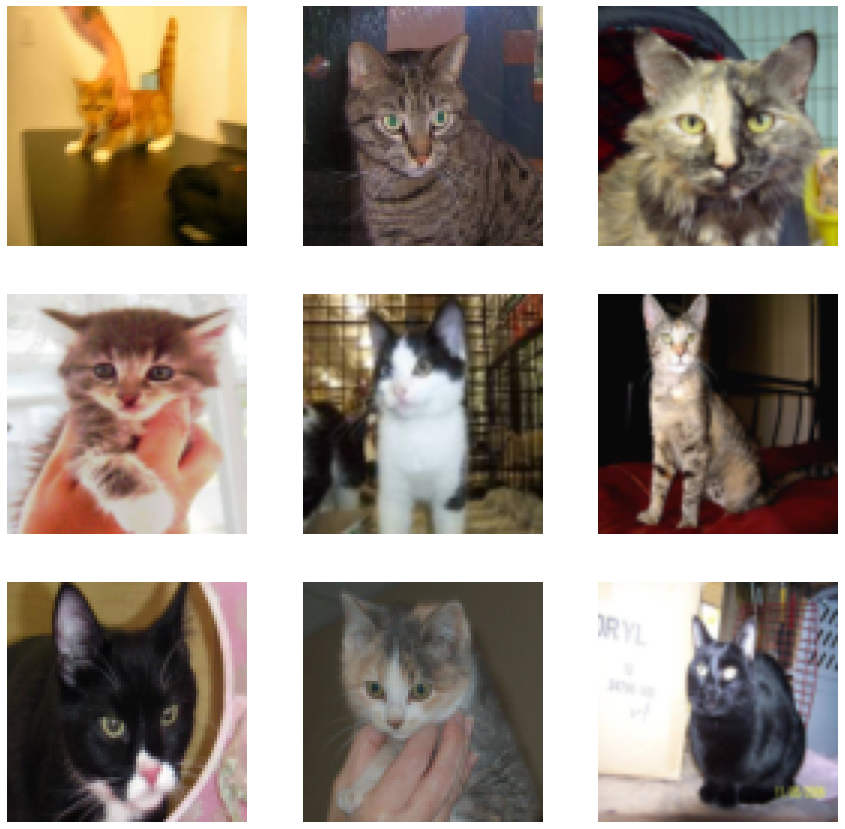

In [49]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from libsvm import svm
import libsvm.svmutil as svmutil
import time
import PIL
from imgaug import augmenters as iaa


class Image2HogFeature:
  def __init__(self):
    self.hog_describer = hog
    self.kwargs = {"pixels_per_cell":(16, 16), "cells_per_block":(3, 3), "visualize":False, "multichannel":True}
  def __call__(self, sample):
    feature = self.hog_describer(sample.permute(1,2,0).numpy(), **self.kwargs)
    '''ndarray'''
    return feature

TRAIN_SOURCE = "/content/Cat_Dog_data/train/"
TEST_SOURCE = "/content/Cat_Dog_data/test/"
RESIZE_SHAPE = (80,80)
transform_demo = transforms.Compose([transforms.Resize(RESIZE_SHAPE)])
demo_img_data = ImageFolder(TRAIN_SOURCE, transform=transform_demo)

def show_image(is_gray=True):
  plt.figure(figsize=(15,15))
  for idx, (img, label) in enumerate(demo_img_data):
    if idx == 9:
      break
    plt.subplot(3,3,idx+1)
    if is_gray:
      plt.imshow(img, cmap=plt.cm.gray_r)
    else:
      plt.imshow(img)
    plt.axis('off')
  plt.show()

show_image(False)

## 3. Data Augmentation
It has two ways of Data Augmentation:  
1.  Resize to (224, 224) -> Using Mask which of size is limited by input image to Crop -> Resize to (80,80) -> Random Rotation between (-45, 45) degrees.
2. Resize to (80,80) -> Random Rotation between (-45, 45) degrees.

First Way


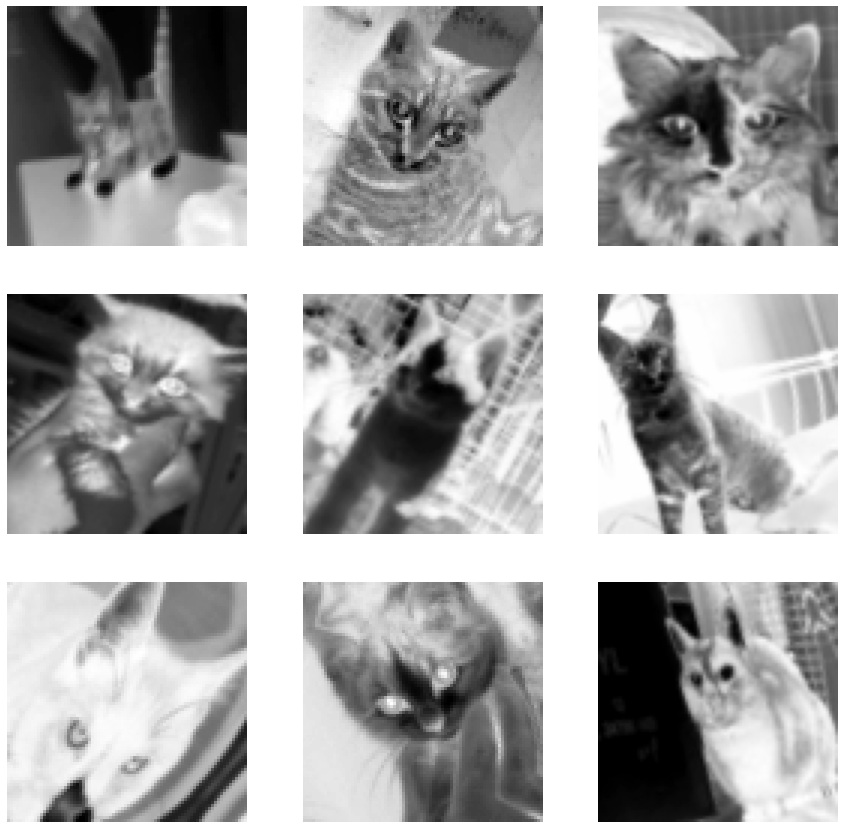

Second Way


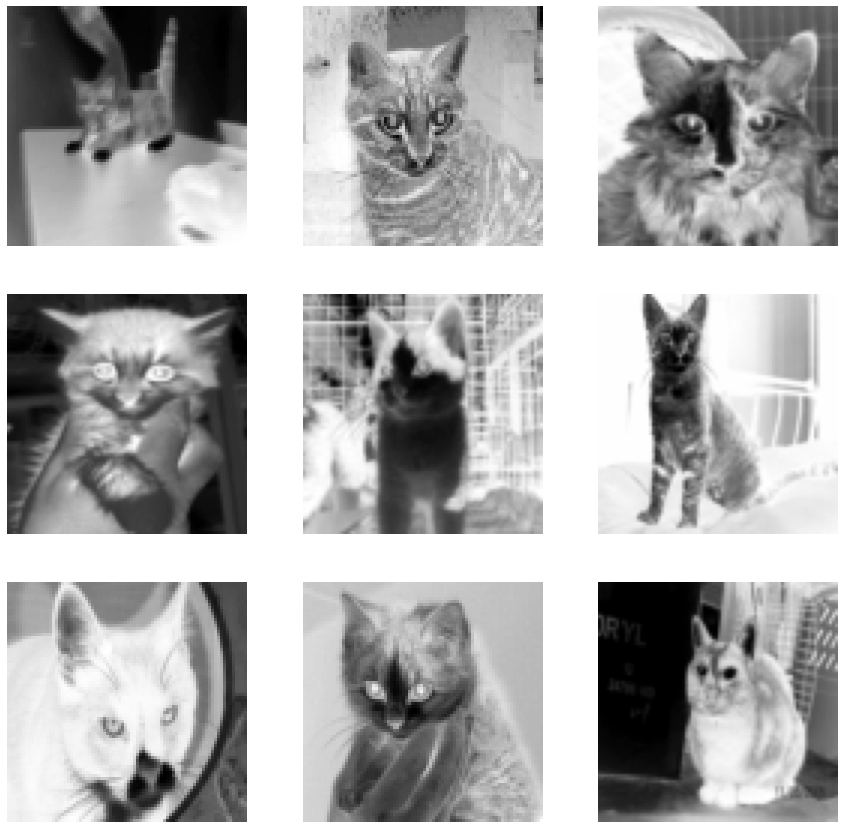

In [50]:
transform1 = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomResizedCrop(80, scale=(0.5625, 1.0)), 
          lambda x: PIL.Image.fromarray(iaa.Affine(rotate=(-45, 45), mode='symmetric').augment(image=np.array(x))).convert('L'),
          ])
transform2 = transforms.Compose([
          transforms.Resize((80,80)),
          lambda x: x.convert('L')
          ])

demo_img_data = ImageFolder(TRAIN_SOURCE, transform=transform1)


print("First Way")
show_image()
demo_img_data = ImageFolder(TRAIN_SOURCE, transform=transform2)
print("Second Way")
show_image()

## 4. Show Hog Feature
cell size : 16 * 16 (pixels)  
block size : 3 * 3 (cells)  
Feature Length : 729


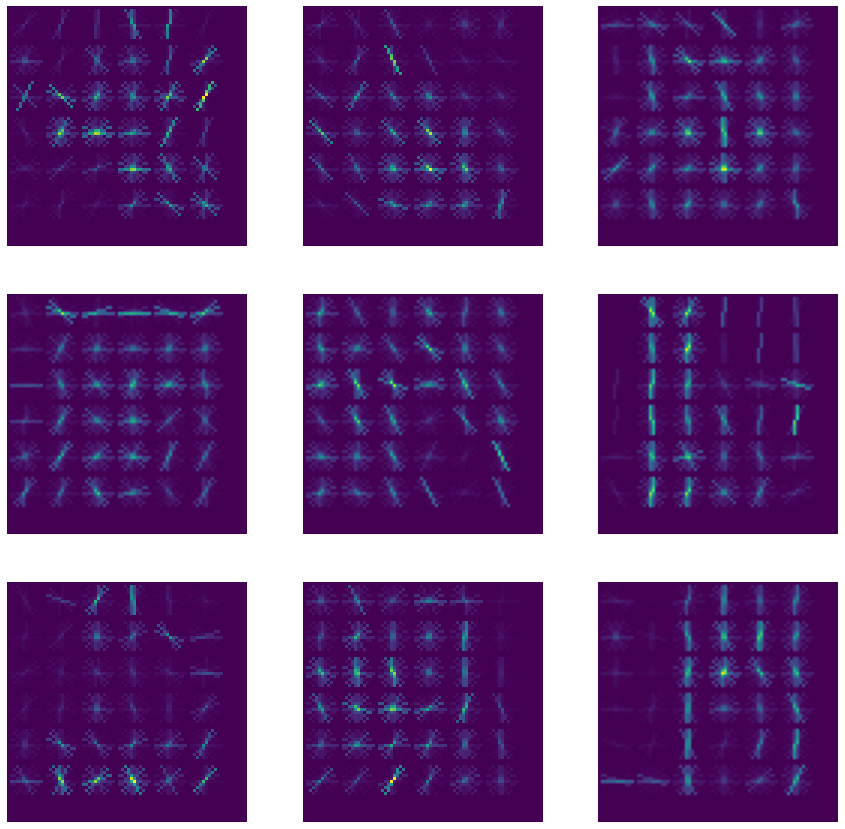

In [53]:
FEARTURE_LENGTH = 1296
demo_img_data =  ImageFolder(TRAIN_SOURCE, transform=transforms.Compose([transforms.RandomChoice([transform1, transform2])]))
def show_hog_feature():
  kwargs = {"pixels_per_cell":(12, 12), "cells_per_block":(3, 3), "visualize":True, "multichannel":None}
  plt.figure(figsize=(15,15))
  for idx, (img, label) in enumerate(demo_img_data):
    if idx == 9:
      break
    plt.subplot(3,3,idx+1)
    feature, visual = hog(np.array(img), **kwargs)
    plt.imshow(visual)
    plt.axis("off")
  plt.show()

show_hog_feature()

## 5. Apply Hog to Dataset

In [55]:
class Image2HogFeature:
  def __init__(self):
    self.hog_describer = hog
    self.kwargs = {"pixels_per_cell":(12, 12), "cells_per_block":(3, 3), "visualize":False, "multichannel":None}
  def __call__(self, sample):
    feature = self.hog_describer(np.array(sample), **self.kwargs)
    return feature


transform_hog = transforms.Compose([transforms.RandomChoice([transform1, transform2]), Image2HogFeature()])
train_img_data = ImageFolder(TRAIN_SOURCE, transform=transform_hog)
test_img_data = ImageFolder(TEST_SOURCE, transform=transforms.Compose([transforms.Resize((80,80)), lambda x: x.convert('L'), Image2HogFeature()]))

test_x = np.zeros((0, FEARTURE_LENGTH))
start = time.time()
for x, y in test_img_data:
  test_x = np.concatenate((test_x, x[np.newaxis, :]))
print(f"using {time.time()-start}s.")

dataset_scale = 2
training_x = np.zeros((0, FEARTURE_LENGTH))
start = time.time()
for i in range(dataset_scale):
  for x, y in train_img_data:
    training_x = np.concatenate((training_x, x[np.newaxis, :]))
print(f"using {time.time() - start}s.")

training_y = np.concatenate([np.array(train_img_data.targets) for _ in range(dataset_scale)])
test_y = np.array(test_img_data.targets)

using 30.406468152999878s.
using 2900.166709423065s.


## 5. Build SVM Classifer: Training Phase
using Radial basis function kernel

In [56]:
start = time.time()
model = svmutil.svm_train(training_y, training_x)
print(f"using {time.time() - start}s.")

using 7391.964720726013s.


## 6. Build SVM Classifer: Testing Phase
using Radial basis function kernel

In [57]:
start = time.time()
p_label, p_acc, p_val = svmutil.svm_predict(test_y,test_x, model)
print(f"using {time.time()-start}s.")

Accuracy = 70.6% (1765/2500) (classification)
using 389.4765965938568s.


## 7. Build Confusion Matrix

In [58]:
class confusion_matrix:
  '''Plot confusion matrix'''

  def __init__(self, cat_name, yTrue, yPred, normalize=True, cmap=plt.cm.Blues):
    '''
    cat_name: list, list of category name, corresponding to integer labels
    self.cf_mat: None or tuple, (figure, axes) from plt.subplot
    '''
    self.cf_mat = None
    if not isinstance(cat_name, list):
      raise Exception('cat_name should be list.')
    if not (isinstance(yTrue, np.ndarray) and len(yTrue.shape) == 1):
      raise Exception('yTrue should be 1 dim ndarray.')
    if not (yTrue.dtype == np.dtype(int).type and yPred.dtype == np.dtype(int).type):
      raise Exception('data type of yTrue and yPred should be int base.')

    self.cf_mat = self.plot_confusion_matrix(cat_name, yTrue, yPred, normalize, cmap=plt.cm.Blues)


  @staticmethod
  def confusion_matrix(cat_name, yTrue, yPred):
    '''
    yTrue: 1-d ndarray, int, target 
    yPred: 1-d ndarray, int, same length as yTrue, predicted result
    '''

    how_many_classes = len(cat_name)
    yPair = np.c_[yTrue, yPred]
    confusion_matrix = np.zeros((how_many_classes, how_many_classes))
    for x, y in yPair:
        confusion_matrix[x,y] += 1
    return confusion_matrix

  def plot_confusion_matrix(self, class_name, yTrue, yPred, normalize=True, cmap=plt.cm.Blues):
      confumat = self.confusion_matrix(class_name, yTrue, yPred)
      if normalize:
          title = 'confusion matrix,\nwith normalization'
          confumat = confumat.astype(float) / confumat.sum(axis=1)[:, np.newaxis]
          confumat[np.isnan(confumat)] = 0.
      else:
          title = 'Confusion matrix,\nwithout normalization'
          confumat = confumat.astype(int)

      # print(confumat)
      if len(class_name) == 2:
        font_size = 10
      elif len(class_name) > 2:
        font_size = 14
      elif len(class_name) > 5:
        font_size = 16
      plt.rcParams.update({'font.size': font_size})
      fig, ax = plt.subplots(figsize=[1.5*len(class_name), 1.5*len(class_name)])
      im = ax.imshow(confumat, interpolation = 'nearest', cmap = cmap)
      ax.figure.colorbar(im, ax=ax)

      ax.set(xticks=np.arange(confumat.shape[1]), yticks=np.arange(confumat.shape[0]),
            xticklabels = class_name, yticklabels = class_name,
            title = title, ylabel = 'True label', xlabel = 'Predicted label')
      plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')

      fmt = '.2f' if normalize else 'd'
      thresh = confumat.max() / 2.
      for i in range(confumat.shape[0]):
          for j in range(confumat.shape[1]):
              ax.text(j, i, format(confumat[i, j], fmt),
                      ha = 'center', va = 'center', fontsize = font_size,
                      color = 'white' if confumat[i, j] > thresh else 'black')
      fig.tight_layout()
      return fig, ax

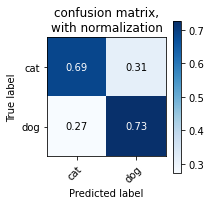

In [59]:
cfmat = confusion_matrix(['cat', 'dog'], test_y, np.array(p_label).astype(int))